In [1]:
"""
Perform a sensitivity Analysis using the Morris Method to obtain the VPRM parameters for a station
"""

from SALib.sample.morris import sample
from SALib.analyze.morris import analyze
import numpy as np
from VPRM_offline.src.Offline_VPRM_for_Morris import preprocess_vprm_for_morris
# from VPRM_offline.src.get_modis_point import get_modis_point

from VPRM_offline.src.Offline_VPRM_for_Morris import vprm_station_for_morris
from VPRM_offline.src.Offline_VPRM_for_Morris import flatten_list_2d
from sys import exit
from os import listdir
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from csv import writer


In [2]:
"""
1. Introduction
"""

cwd = '/data/co2flux/common/mdomhoef/Oslo/Oslo_analysis/'
year = 2018
StationDataPath = cwd + 'data/HH_Data_small/'
sitename = 'FI-Let' #code of the station
tag = 'Sentinel' #'MODIS', 'MODIS_pp'

iveg = 1 #PFT +1 index of the station
year = 2018 #Year to perform the analysis
input_origin = 'ERA5' #Input origin for the meteorological data
# pathout = '/home/users/rsegura/Scripts/plots/'

stations_file = cwd + 'Stations.csv'
years_file = cwd + 'Station_years.csv'

#PFT Stations
#1. Evergreen needleleaf Forest - ESES1,FRFBn,FRLBr
#2. Broadleaf deciduous Forest - PTEsp, 
#3. Mixed Forest
#4. Mixed shrubland/grassland
#5. Savanna
#6. Dryland cropland and pasture
#7. Grassland
#8. Others
#################
#9. Cropland/woodland mosaic

#VPRM parameters from WRF
parameters = {1:[275.4595, 0.22577703, 0.28773167, -1.09316696, 0., 40, 20.],
              2:[254.4188, 0.21489270, 0.18056630, 0.83641734, 0., 40, 20.,],
              3:[446.0888,0.16293380,0.24447911, -0.48669162, 0., 40, 20.],
              4:[70.3829,0.29311134,0.05464646, -0.12080592, 2., 40, 20.],
              5:[682.0, 0.1141, 0.0049, 0.0000, 2., 40, 20.],
              6:[1132.2, 0.08626603, 0.09231632,0.28788863, 5., 40, 22.],
              7:[527.9303, 0.11930965, 0.1245603, 0.01743361, 2., 40 ,18.],
              8:[0.00, 0.00, 0.00, 0, 0., 40, 0.]
             } 



In [3]:
stations = pd.read_csv(stations_file, sep = ',', index_col = 0)
years_st = pd.read_csv(years_file, index_col= 0) 

fls = listdir(StationDataPath)
fls = [x for x, y in zip(fls, [(sitename in file) for file in fls]) if y == True]
#get the years and stations with data of year 
# for station in stations['Station'].unique():
if years_st.loc[year][sitename] != 1.0:
    print(f"For this station {sitename} the year {year} data does not exist")
else: 
    Flux_file = fls[0]
    
    lon = stations.loc[sitename, 'Longitude']
    lat = stations.loc[sitename, 'Latitude']
    tile = [stations.loc[sitename, 'tile_h'], stations.loc[sitename, 'tile_v']]
    veg_type = stations.loc[sitename, 'VPRM']
print(Flux_file)

new_FLX_FI-Let_FLUXNET2015_FULLSET_HH_2009-2020_beta-3.csv


In [4]:
df_obs = pd.read_table(StationDataPath+Flux_file, sep=',', index_col = 0)
df_obs['TIMESTAMP_START']= pd.to_datetime(df_obs['TIMESTAMP_START'], format='%Y%m%d%H%M')
df_obs['year'] = df_obs['TIMESTAMP_START'].dt.year
df_obs = df_obs[df_obs['year']==2018]
if 'NEE_VUT_REF' in df_obs.columns:
    label = 'NEE_VUT_REF'
else:
    label = 'FC'

df_obs.loc[df_obs[label] < -9990, label] = np.nan
df_obs[label] = df_obs[label]*3600
df_obs.set_index('TIMESTAMP_START', inplace=True)
df_obs = df_obs[[label]]

NEE_obs = df_obs[label].values

In [5]:
"""
3. Run the preprocess_vprm_for_morris function to obtain the MODIS indices and the meteorology
"""

EVI, EVImax, EVImin, LSWI, LSWImax, LSWImin, Temp, Rad = preprocess_vprm_for_morris(sitename = sitename, year = year, lat = lat, lon = lon, tile = tile, input_origin = 'ERA5', sat_input = tag)


getting Sentinel Data for  FI-Let  station  2018
[21185.         21185.02083333 21185.04166667 ... 21549.9375
 21549.95833333 21549.97916667]
fjulm: (365,) fjul:  (365,) fjulout (17520,) data1  (365,) date2  (365,) EVI (17520,)
getting met data at FI-Let station


In [6]:
"""
4. Declare problem of the sensitivity analysis.
"""
problem = {
    'num_vars': 7,
    'names': ['lambdaGPP', 'radZero', 'alpha', 'beta', 'Tmin', 'Tmax', 'Topt'],
    'bounds': [[0.2, 0.45],
               [100, 250],
               [0.1, 0.2],
               [0.0, 1],
               [-1, 1],
               [39, 41],
               [19, 21]]
}
X = sample(problem, 1000, num_levels=6)


In [7]:
"""
5. Run the model for each set of parameters
"""

Y = []
RMSE = []

for i in range(len(X)):
    GEE, RSP, NEE = vprm_station_for_morris(sitename, year, iveg, X[i], EVI, LSWI, EVImax, EVImin, LSWImax, LSWImin, Temp, Rad)
    df_case = df_obs.copy(deep=True)
    df_case['Simulated GEE'] = GEE
    df_case['Simulated RSP'] = RSP
    df_case['Simulated NEE'] = NEE
    mean_NEE = df_case['Simulated NEE'].mean()
    Y.append(mean_NEE)
    df_case = df_case.dropna(axis=0)
    RMSE.append(np.mean((df_case['Simulated NEE'] - df_case[label]) ** 2) ** .5)

In [41]:
"""
6. Analyze  Morris indices
"""
Y = np.array(Y)

Si = analyze(problem, X, Y, conf_level=0.95,
             print_to_console=True, num_levels=6)



                    mu      mu_star         sigma  mu_star_conf
lambdaGPP -7629.816783  7629.816783  1.440958e+03  9.070743e+01
radZero   -5367.695750  5367.695750  1.530317e+03  1.036887e+02
alpha      3289.424151  3289.424151  4.351140e-12  3.469336e-13
beta       3600.000000  3600.000000  1.145598e-12  0.000000e+00
Tmin        454.622531   455.861270  1.460555e+02  8.216659e+00
Tmax       -105.101966   105.101966  3.296120e+01  2.254553e+00
Topt        341.854633   341.854633  1.023283e+02  6.613576e+00


In [50]:
# s = pd.DataFrame(Si)
# s[sitename] = X[ind]
# s

,names,mu,mu_star,sigma,mu_star_conf,FI-Hyy
0,lambdaGPP,-7629.816783,7629.816783,1.440958e+03,9.070743e+01,0.3
1,radZero,-5367.695750,5367.695750,1.530317e+03,1.036887e+02,250.0
2,alpha,3289.424151,3289.424151,4.351140e-12,3.469336e-13,0.2
3,beta,3600.000000,3600.000000,1.145598e-12,0.000000e+00,0.4
4,Tmin,454.622531,455.861270,1.460555e+02,8.216659e+00,-0.6
5,Tmax,-105.101966,105.101966,3.296120e+01,2.254553e+00,40.2
6,Topt,341.854633,341.854633,1.023283e+02,6.613576e+00,19.8


In [42]:
"""
7. Check best configuration output
"""
ind = np.where(RMSE == np.min(RMSE))[0][0]
print(X[ind])
GEE, RSP, NEE = vprm_station_for_morris(sitename, year, iveg, X[ind], EVI, LSWI, EVImax, EVImin, LSWImax, LSWImin, Temp, Rad)
print(NEE.shape)
df_opt = df_obs.copy(deep=True)
wrf_convert = 24*44/1000000
df_opt['NEE'] = NEE*wrf_convert
df_opt[label] = df_opt[label]*wrf_convert
unit = '($\mathrm{g_{CO_2} m^{-2} day^{-1}}$)'

[ 3.00e-01  2.50e+02  2.00e-01  4.00e-01 -6.00e-01  4.02e+01  1.98e+01]
(17520,)


In [43]:
def append_list_as_row(file_name, list_of_elem):
    # Open file in append mode
    with open(file_name, 'a+', newline='') as write_obj:
        # Create a writer object from csv module
        csv_writer = writer(write_obj)
        # Add contents of list as last row in the csv file
        csv_writer.writerow(list_of_elem)
        

In [44]:
row_contents = list(X[ind]) + [sitename]
print(row_contents)
append_list_as_row('Oslo_analysis/VPRMoutput/best_fit_morris.csv', row_contents)

[0.30000000000000004, 250.0, 0.2, 0.4, -0.6, 40.2, 19.8, 'FI-Hyy']


                     NEE_VUT_REF       NEE
TIMESTAMP_START                           
2018-01-01 00:00:00     2.387686  3.801600
2018-01-01 00:30:00     2.412294  3.801600
2018-01-01 01:00:00     2.419623  3.801600
2018-01-01 01:30:00     2.419623  3.801600
2018-01-01 02:00:00     2.417886  3.801600
...                          ...       ...
2018-12-31 21:30:00     4.181874  5.729159
2018-12-31 22:00:00     4.276040  5.769381
2018-12-31 22:30:00     4.570360  5.822286
2018-12-31 23:00:00     3.873222  5.875190
2018-12-31 23:30:00     4.694596  5.928095

[17520 rows x 2 columns]


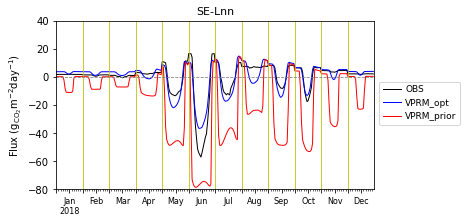

In [10]:
params = [0.3084, 270.2, 0.1797, 0.8800, 0, 40, 20]
params = parameters[iveg]
# params = X[ind]
print(df_opt)

GEE, RSP, NEE = vprm_station_for_morris(sitename, year, iveg, params, EVI, LSWI, EVImax, EVImin, LSWImax, LSWImin, Temp, Rad)
#df_nonopt = df_obs.copy()
df_opt['NEE_prior'] = NEE*wrf_convert
#df_nonopt = df_nonopt[['NEE_prior']]


begin = [datetime.datetime(year, 1, 1, 0, 0, 0), datetime.datetime(year, 2, 1, 0, 0, 0), datetime.datetime(year, 3, 1, 0, 0, 0),
             datetime.datetime(year, 4, 1, 0, 0, 0), datetime.datetime(year, 5, 1, 0, 0, 0), datetime.datetime(year, 6, 1, 0, 0, 0),
             datetime.datetime(year, 7, 1, 0, 0, 0), datetime.datetime(year, 8, 1, 0, 0, 0), datetime.datetime(year, 9, 1, 0, 0, 0),
             datetime.datetime(year, 10, 1, 0, 0, 0), datetime.datetime(year, 11, 1, 0, 0, 0), datetime.datetime(year, 12, 1, 0, 0, 0)]
end = [datetime.datetime(year, 1, 31, 23, 0, 0), datetime.datetime(year, 2, 28, 23, 0, 0), datetime.datetime(year, 3, 31, 23, 0, 0),
           datetime.datetime(year, 4, 30, 23, 0, 0), datetime.datetime(year, 5, 31, 23, 0, 0), datetime.datetime(year, 6, 30, 23, 0, 0),
           datetime.datetime(year, 7, 31, 23, 0, 0), datetime.datetime(year, 8, 31, 23, 0, 0), datetime.datetime(year, 9, 30, 23, 0, 0),
           datetime.datetime(year, 10, 31, 23, 0, 0), datetime.datetime(year, 11, 30, 23, 0, 0), datetime.datetime(year, 12, 31, 23, 0, 0)]

sim_nee = []
sim_nonopt_nee = []
obs_nee = []
for month in range(len(begin)):

    df_opt_m = df_opt[begin[month]:end[month]]
    df_opt_mean = df_opt_m.groupby([df_opt_m.index.hour]).mean()
    obs_nee.append(df_opt_mean[label])

    sim_nee.append(df_opt_mean.NEE)

    sim_nonopt_nee.append(df_opt_mean.NEE_prior)
    

sim_nee = flatten_list_2d(sim_nee)
obs_nee = flatten_list_2d(obs_nee)
sim_nonopt_nee = flatten_list_2d(sim_nonopt_nee)

time_day = np.arange(0,288)
fig,ax = plt.subplots(figsize=(6.5,3))
plt.subplots_adjust(left=0.13, right=0.81, top=0.9, bottom=0.12)
colors = ['b','m','c']
ax.plot(time_day, obs_nee, linewidth=1, color='k', label='OBS')
ax.plot(time_day, sim_nee, linewidth=1, color = 'b', label='VPRM_opt')
ax.plot(time_day, sim_nonopt_nee, linewidth=1, color = 'r', label='VPRM_prior')

legend=ax.legend(loc='center left', shadow=False, fontsize=9, ncol=1, handletextpad=0.5, bbox_to_anchor=(1., 0.512))
ax.set_xlim(0, 288)
ax.set_ylim(-80, 40)
for tt in range(24,288,24):
    ax.axvline(tt, color='y', linewidth=0.8)
ax.axhline(0, color='grey', linewidth=0.8, linestyle='--')
plt.ylabel('Flux '+unit, fontsize=10)
major_ticks = np.arange(0, 288, 12)
minor_ticks = np.arange(0, 288, 2)
ax.xaxis.set_ticks(major_ticks)
#ax.set_xticklabels([0,12,0,12,0,12,0,12,0,12,0,12,0,12,0,12,0,12,0,12,0,12,0,12,0,12,0,12,0,12,0,12])
ax.set_xticklabels(['','Jan\n'+str(year),'','Feb','','Mar','','Apr','','May','','Jun','','Jul','','Aug','','Sep','','Oct','','Nov','','Dec'])
ax.xaxis.set_ticks(minor_ticks, minor = True)
ax.xaxis.set_tick_params(which='major', labelsize=8)
ax.set_title(sitename, fontsize=11)
pathout = cwd
plt.savefig(pathout+sitename+'_diurnal_'+str(year)+'.png',dpi=300)


In [11]:
outpath = '/data/co2flux/common/mdomhoef/Oslo/Oslo_analysis/VPRMoutput/'
df_opt.to_csv(outpath+'VPRM.MORRIS_'+sitename+'_'+tag+'_'+str(year)+'.csv', index = False, header=True)
df_opt.head(10)


,NEE_VUT_REF,NEE,NEE_prior
TIMESTAMP_START,,,
2018-01-01 00:00:00,2.387686,3.8016,0.219579
2018-01-01 00:30:00,2.412294,3.8016,0.219579
2018-01-01 01:00:00,2.419623,3.8016,0.219579
2018-01-01 01:30:00,2.419623,3.8016,0.219579
2018-01-01 02:00:00,2.417886,3.8016,0.219579
2018-01-01 02:30:00,2.433317,3.8016,0.219579
2018-01-01 03:00:00,2.440220,3.8016,0.219579
2018-01-01 03:30:00,2.474796,3.8016,0.219579
2018-01-01 04:00:00,2.494302,3.8016,0.219579
